# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 49.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=8c2081b883f670a4edc7c5af3cfcddd4b2ccb84bb68f5136efabd5cbb219105f
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=d9bb8cab9ecc9d7f585cbf65244e7f4e52b2953cbc854bf74313c0fc1845bc5d
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumenta

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 16.72 MiB/s, done.
Resolving deltas: 100% (3/3), done.


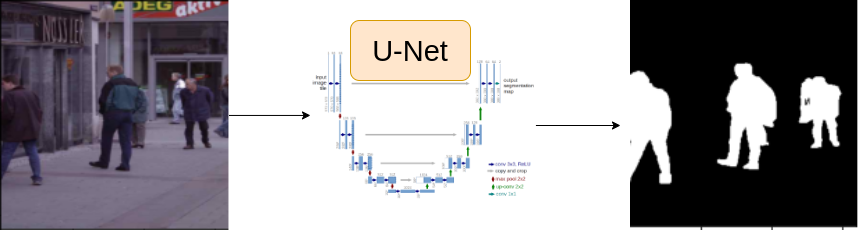

# Some Common Imports

In [ ]:
import sys
sys.path.append('Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = 'Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = ''

device = "cuda"

epochs = 25
lr = 0.003
image_size = 320
batch_size = 16

encoder = 'timm-efficientnet-b0'
weights = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.iloc[4]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #since cv reads image in BGR

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0

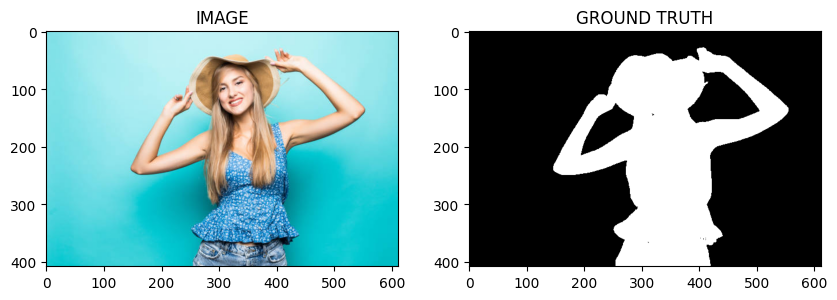

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
    A.Resize(image_size, image_size),
    A.HorizontalFlip(p = 0.5),
    A.VerticalFlip(p = 0.5),
  ], is_check_shapes=False)

def get_val_augs():
  return A.Compose([
      A.Resize(image_size, image_size),
  ], is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentation):
    self.df = df
    self.augmentations = augmentation

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #since cv reads image in BGR

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0
    mask = np.expand_dims(mask, axis = -1) # add channel dim at end

    # print(image.shape, mask.shape)
    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    #(h,w,c) to (c,h,w)
    image  = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask)) #no need to scale alread [0,1]

    return image, mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_val_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


torch.Size([1, 320, 320])

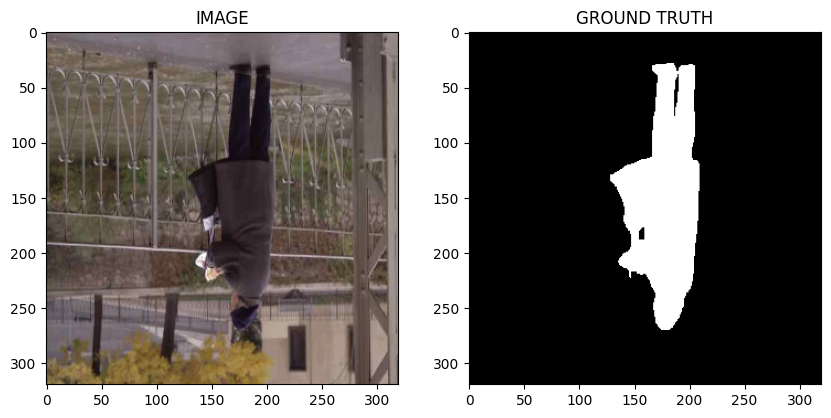

In [ ]:
idx = 4

image, mask = trainset[idx]

helper.show_image(image, mask)
mask.shape

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=True)

In [ ]:
print(f"# Batches in train: {len(trainloader)}, valid: {len(validloader)}")

# Batches in train: 15, valid: 4


In [ ]:
for image, mask in trainloader:
  break
print(f"One batch image shape: {image.shape}, mask: {mask.shape}")

One batch image shape: torch.Size([16, 3, 320, 320]), mask: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
import torch.nn as nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()
    self.arch = smp.Unet(
        encoder_name = encoder,
        encoder_weights = weights,
        in_channels = 3,
        classes = 1,
        activation = None # final ouputs as logits, not sigmoid
    )

  def forward(self, images, masks = None):
    logits = self.arch(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)

      return logits, loss1+loss2 # for training

    return logits # for testing/inference

In [ ]:
model = SegmentationModel()
model.to(device)

SegmentationModel(
  (arch): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
          

# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(data_loader, model, optimizer):
  model.train() # puts model to train model. activates dropout etc
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(device)
    masks = masks.to(device)

    optimizer.zero_grad()
    logits, loss = model(images, masks)

    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [ ]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(device)
      masks = masks.to(device)

      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss / len(data_loader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
best_validation_loss = np.Inf

for i in range(epochs):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_validation_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("Model saved")
    best_validation_loss = valid_loss

  print(f"Epoch {i+1} train loss: {train_loss}, valid loss: {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


Model saved
Epoch 1 train loss: 0.24433606664339702, valid loss: 0.24715853855013847


100%|██████████| 4/4 [00:01<00:00,  3.71it/s]


Epoch 2 train loss: 0.23155890603860219, valid loss: 0.24776505306363106


100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


Epoch 3 train loss: 0.22165181636810302, valid loss: 0.27106431871652603


100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


Model saved
Epoch 4 train loss: 0.18338673412799836, valid loss: 0.21507368609309196


100%|██████████| 4/4 [00:00<00:00,  4.65it/s]


Epoch 5 train loss: 0.16072273353735606, valid loss: 0.22483240813016891


100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


Model saved
Epoch 6 train loss: 0.16032691051562628, valid loss: 0.2111615501344204


100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


Epoch 7 train loss: 0.18737888485193252, valid loss: 0.2433122731745243


100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


Epoch 8 train loss: 0.18276882270971934, valid loss: 0.27443668618798256


100%|██████████| 4/4 [00:01<00:00,  4.00it/s]


Epoch 9 train loss: 0.16992162118355433, valid loss: 0.217054795473814


100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


Model saved
Epoch 10 train loss: 0.15267744014660517, valid loss: 0.19375591352581978


100%|██████████| 4/4 [00:01<00:00,  3.36it/s]


Epoch 11 train loss: 0.14883528997500736, valid loss: 0.24661528691649437


100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


Epoch 12 train loss: 0.1400687997539838, valid loss: 0.2205502949655056


100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


Epoch 13 train loss: 0.18749771962563197, valid loss: 0.34188172593712807


100%|██████████| 4/4 [00:01<00:00,  3.92it/s]


Epoch 14 train loss: 0.13263412564992905, valid loss: 0.23511095717549324


100%|██████████| 4/4 [00:00<00:00,  4.66it/s]


Model saved
Epoch 15 train loss: 0.11004295100768408, valid loss: 0.18477538228034973


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


Epoch 16 train loss: 0.09854394868016243, valid loss: 0.20696155354380608


100%|██████████| 4/4 [00:01<00:00,  2.42it/s]


Epoch 17 train loss: 0.1035323624809583, valid loss: 0.19255682080984116


100%|██████████| 4/4 [00:01<00:00,  3.59it/s]


Epoch 18 train loss: 0.0988857572277387, valid loss: 0.20964833162724972


100%|██████████| 4/4 [00:01<00:00,  3.06it/s]


Model saved
Epoch 19 train loss: 0.10507180591424306, valid loss: 0.16684001497924328


100%|██████████| 4/4 [00:01<00:00,  3.14it/s]


Epoch 20 train loss: 0.10372072756290436, valid loss: 0.25719887018203735


100%|██████████| 4/4 [00:01<00:00,  3.76it/s]


Epoch 21 train loss: 0.1231344036757946, valid loss: 0.3107641637325287


100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


Epoch 22 train loss: 0.15268727640310922, valid loss: 0.21081922575831413


100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


Epoch 23 train loss: 0.12243993083635966, valid loss: 0.22669321298599243


100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


Epoch 24 train loss: 0.10257623493671417, valid loss: 0.23909712210297585


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]

Model saved
Epoch 25 train loss: 0.08933674842119217, valid loss: 0.16088293492794037


# Task 9 : Inference

In [ ]:
idx = 5

model.load_state_dict(torch.load('/content/best_model.pt'))
image, mask = validset[idx]

logits_mask = model(image.to(device).unsqueeze(0)) # unsqueeze to add batch dim

pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0 # boolean to numeric

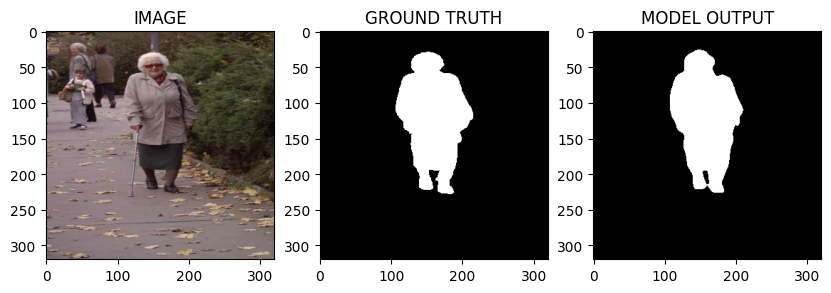

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))